# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.754725,True,8.082784
1,-1.004774,True,1.928275
2,0.163193,True,5.643386
3,-0.123047,True,5.097834
4,-2.038349,True,0.213173
...,...,...,...
995,-1.671781,False,-1.791110
996,-1.599372,True,1.008945
997,0.049237,False,0.264254
998,-0.828187,False,-2.585414


<Axes: xlabel='v0'>

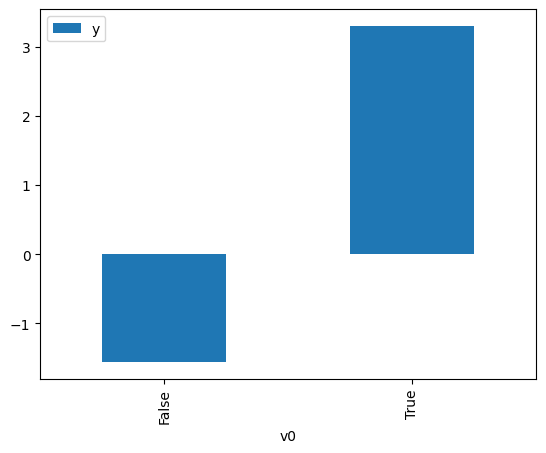

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

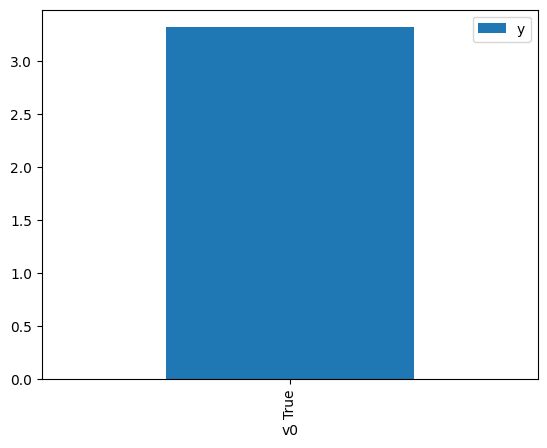

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.235865,False,-0.101573,0.550174,1.817606
1,0.266964,False,0.823559,0.472063,2.118362
2,-0.040952,False,0.337947,0.519977,1.923160
3,0.699670,False,2.353977,0.405784,2.464364
4,-0.733240,False,-1.592384,0.625092,1.599765
...,...,...,...,...,...
995,0.006529,False,1.742234,0.512591,1.950874
996,-1.923872,False,-4.314782,0.777806,1.285667
997,-1.250148,False,-1.280582,0.697037,1.434644
998,1.276534,False,2.578257,0.322833,3.097575


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.003893,True,3.103019,0.336301,2.973525
1,-1.117666,True,3.619669,0.320669,3.118476
2,0.254470,True,3.437587,0.525997,1.901151
3,-0.403438,True,4.627105,0.424149,2.357664
4,-0.161309,True,4.409625,0.461345,2.167576
...,...,...,...,...,...
995,-0.789662,True,1.436541,0.366708,2.726965
996,0.017474,True,5.773238,0.489113,2.044518
997,-1.194508,True,3.276359,0.310332,3.222353
998,-0.571955,True,3.923321,0.398734,2.507939


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6433.
Date:                Tue, 29 Oct 2024   Prob (F-statistic):                        0.00
Time:                        15:46:54   Log-Likelihood:                         -1435.5
No. Observations:                1000   AIC:                                      2875.
Df Residuals:                     998   BIC:                                      2885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2771      0.027     82.851      0.000       2.223       2.331
x2             4.8984      0.053     92.617      0.000       4.795       5.002
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.481
Skew:                          -0.029   Prob(JB):                        0.786
Kurtosis:                       2.910   Cond. No.                         1.99
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""